In [66]:
import yfinance as yf
import talib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier




df = yf.download("AAPL", start="2020-01-01", end="2023-01-01", auto_adjust=True)
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]


[*********************100%***********************]  1 of 1 completed


In [67]:
df.columns = ['_'.join(filter(None, col)) for col in df.columns]


In [68]:
df['rsi'] = talib.RSI(df['Close_AAPL'], timeperiod=14)
df['ema10'] = talib.EMA(df['Close_AAPL'], timeperiod=10)
df['ema50'] = talib.EMA(df['Close_AAPL'], timeperiod=50)
df['macd'], df['macd_signal'], _ = talib.MACD(df['Close_AAPL'])


In [69]:
# Define target variable for classification and regression
df['next_close'] = df['Close_AAPL'].shift(-1)

In [70]:
# For classification: 1 if price goes up, else 0
df['target_cls'] = (df['next_close'] > df['Close_AAPL']).astype(int)


In [71]:
df.dropna(inplace=True)

In [45]:
# For regression: predict actual next close price
df['target_reg'] = df['next_close']


In [73]:
# Select features and target
X = df[['rsi', 'ema10', 'ema50', 'macd', 'macd_signal']]
y_cls = df['target_cls']


In [74]:
# Define ML models to compare
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(n_estimators=100),
    'GradientBoosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(eval_metric='logloss')
}


In [75]:
# Use time series split to simulate realistic training/testing
tscv = TimeSeriesSplit(n_splits=5)
model_results = {}

for name, model in models.items():
    accs, f1s = [], []
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y_cls.iloc[train_idx], y_cls.iloc[test_idx]

        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        accs.append(accuracy_score(y_test, preds))
        f1s.append(f1_score(y_test, preds))

    model_results[name] = {
        'accuracy': np.mean(accs),
        'f1_score': np.mean(f1s)
    }


 

In [76]:
# Display model comparison
results_df = pd.DataFrame(model_results).T.sort_values(by='accuracy', ascending=False)
print("\nModel Comparison:")
print(results_df)



Model Comparison:
                    accuracy  f1_score
XGBoost             0.524786  0.481479
GradientBoosting    0.516239  0.482221
RandomForest        0.499145  0.428555
LogisticRegression  0.487179  0.281014


In [77]:
# Use best model (XGBoost) for strategy simulation
best_model = models['XGBoost']
best_model.fit(X, y_cls)
df_filtered = X.copy()
df_filtered['Close_AAPL'] = df['Close_AAPL'].values
df_filtered['pred_signal'] = best_model.predict(X)


In [79]:
# Simulate trading strategy
df_filtered['strategy_return'] = df_filtered['Close_AAPL'].pct_change().shift(-1) * df_filtered['pred_signal']
df_filtered['cum_strategy'] = (1 + df_filtered['strategy_return']).cumprod()
df_filtered['cum_buy_and_hold'] = (1 + df_filtered['Close_AAPL'].pct_change()).cumprod()


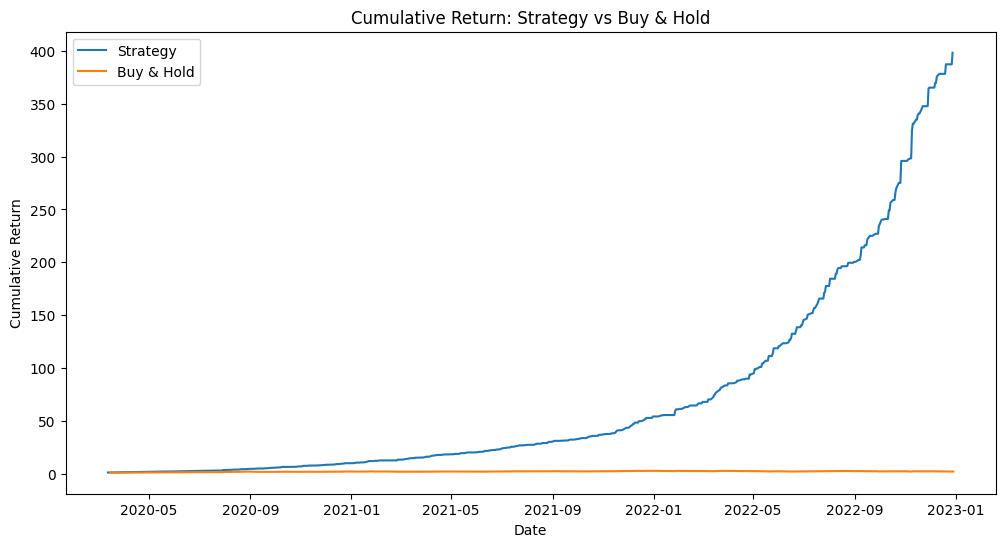

In [80]:
# Plot strategy vs Buy & Hold
plt.figure(figsize=(12, 6))
plt.plot(df_filtered.index, df_filtered['cum_strategy'], label='Strategy')
plt.plot(df_filtered.index, df_filtered['cum_buy_and_hold'], label='Buy & Hold')
plt.title("Cumulative Return: Strategy vs Buy & Hold")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
